In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [1]:
import numpy as np
import pandas as pd
from scipy.misc import derivative
import scipy.integrate as intg
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow.keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import RMSprop
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal


from astroNN.nn.layers import MCDropout
# import scipy as sp
# from scipy.interpolate import interp1d

2023-03-24 13:14:04.036998: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-24 13:14:04.122016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 13:14:04.122034: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-24 13:14:04.704144: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [6]:
file = '../data/pantheon+_lcparam_full_long_zhel.txt'
syscov_file = '../data/pantheon+_sys_full_long.txt'
# file = 'data/lcparam_full_long.txt'
df = pd.read_csv(file, sep = " ", usecols=['zHD', 'm_b_corr'])
# df = pd.read_csv(file, sep = " ")
N = len(df.values)
syscov = np.loadtxt(syscov_file, skiprows=1).reshape((N, N))
cov = np.copy(syscov)

In [7]:
df.head()

,zHD,m_b_corr
0,0.00122,9.74571
1,0.00122,9.80286
2,0.00256,11.47030
3,0.00256,11.49190
4,0.00299,11.52270


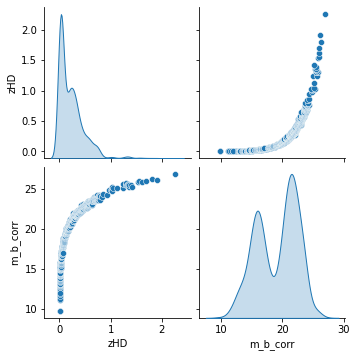

In [8]:
sns.pairplot(df, diag_kind="kde")

In [9]:
np.diag_indices_from(cov)

(array([   0,    1,    2, ..., 1698, 1699, 1700]),
 array([   0,    1,    2, ..., 1698, 1699, 1700]))

In [24]:
# ww = (df['zHD']>0.01)
# ii = -1
# f = open(syscov_file)
# line = f.readline()
# n = int(len(df))
# C = np.zeros((n,n))
# for i in range(len(df)):
#     jj = -1
#     if ww[i]:
#         ii += 1
#         for j in range(len(df)):
#             if ww[j]:
#                 jj += 1
#             val = float(f.readline())
#             if ww[i]:
#                 if ww[j]:
#                     C[ii,jj] = val
# cov = C

In [25]:
# np.diag(C)

array([-0.00018869,  0.00087501,  0.00198121, ...,  0.        ,
        0.        ,  0.        ])

In [27]:
sq_errors = np.diag(syscov)

In [28]:
# df['errors'] = np.sqrt(sq_errors+dmag**2)
df['errors'] = np.sqrt(sq_errors)
df.describe()

,zHD,m_b_corr,errors
count,1701.000000,1701.000000,1701.000000
mean,0.221229,19.083629,0.169411
std,0.249271,3.374499,0.059434
min,0.001220,9.745710,0.080278
25%,0.027730,16.036200,0.128216
50%,0.163750,20.076300,0.155560
75%,0.328680,21.824800,0.195335
max,2.261370,26.929800,0.625326


In [29]:
# df['mb'] += 19.36

Text(0, 0.5, '$\\mu(z)$')

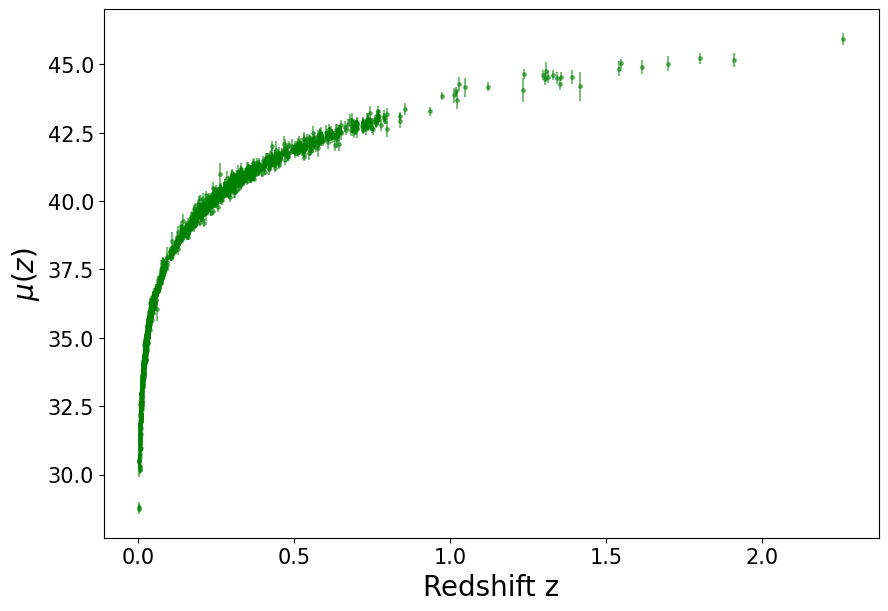

In [31]:
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(df['zHD'], df['m_b_corr']+19, df['errors'], fmt='g.', markersize=5, label='Observations', alpha=0.5)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.xscale('log')


plt.ylabel("$\mu(z)$", fontsize=20)
# plt.xlim(0, 2.3)

In [32]:
randomize = np.random.permutation(N)
data = df.values[randomize]

In [33]:
z = data[:,0]
y = data[:,1:]
# print(randomize)

In [34]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery = StandardScaler()
# scalery.fit(y)
# y = scalery.transform(y)

In [35]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [36]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.0,
                                   patience=50.0,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]

In [37]:
def RHSquared_a_owacdm(a, w0, wa, Om):
    rhow = a**(-3*(1.0+w0+wa))*np.exp(-3*wa*(1-a))
    return (Om/a**3+(1.0-Om)*rhow)

def DistIntegrand_a(a, w0, wa, Om):
        return 1./np.sqrt(RHSquared_a_owacdm(a, w0, wa, Om))/a**2
    
def Da_z(z, w0, wa, Om):
        r = intg.quad(DistIntegrand_a, 1./(1+z), 1, args=(w0, wa, Om))
        r = r[0]
        return r

### Hay que revisar esta constante en el return
def distance_modulus(z, w0=-1, wa=0.0, Om=0.23):
    return 5*np.log10(Da_z(z, w0, wa, Om)*(1+z))+24
# +43

zmodel = np.linspace(0.01, 2.4, 100)
flcdm = []
# fowacdm1 = []
# fowacdm2 = []
# fowacdm3 = []

om = 0.27
for zzz in zmodel:
    flcdm.append(distance_modulus(zzz, w0=-1, wa=0, Om=om))

#     fowacdm1.append(distance_modulus(zzz, w0=-1.3, wa=1.2))
#     fowacdm1.append(distance_modulus(zzz, w0=-1.09, wa=0.3, Om=om))
#     fowacdm2.append(distance_modulus(zzz, w0=-1.04, wa=-0.3, Om=om))
#     fowacdm3.append(distance_modulus(zz, model='owacdm', w0=-1, wa=0.0))
    
flcdm = np.array(flcdm)
# fowacdm1 = np.array(fowacdm1)
# fowacdm2 = np.array(fowacdm2)
# fowacdm3 = np.array(fowacdm3)

In [38]:
def model2(input_z):
    x = Dense(50, activation='relu', input_shape=(1,))(input_z)
    x = Dense(200, activation='relu')(x)
    x = Dense(150, activation='relu')(x)
    elast = Dense(2, activation='linear')(x)


    return elast


input_z = Input(shape = (1,))
neural_model2 = Model(input_z, model2(input_z))
neural_model2.compile(loss='mean_squared_error', optimizer = "adam")
neural_model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 50)                100       
                                                                 
 dense_1 (Dense)             (None, 200)               10200     
                                                                 
 dense_2 (Dense)             (None, 150)               30150     
                                                                 
 dense_3 (Dense)             (None, 2)                 302       
                                                                 
Total params: 40,752
Trainable params: 40,752
Non-trainable params: 0
_________________________________________________________________


2023-03-24 13:37:34.489026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-24 13:37:34.489582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-24 13:37:34.489811: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-24 13:37:34.489995: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-24 13:37:34.490178: W tensorflow/c

#### Ahora usando incertidumbres de la red con Monte Carlo Dropout

In [39]:
yy = y[:,0].reshape(-1,1)
zz = z
split = 0.8
ntrain = int(split * len(zz))
indx = [ntrain]
zz_train, zz_test = np.split(zz, indx)
yy_train, yy_test = np.split(yy, indx)
np.shape(zz_train), np.shape(yy_train), np.shape(zz_test), np.shape(yy_test)

((1360, 1), (1360, 1), (341, 1), (341, 1))

In [40]:
def model_regression_dropout(num_hidden):
    # Defeine Keras model for regression
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[1], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=num_hidden[2], 
#                     kernel_regularizer=tf.keras.regularizers.l2(1e-4),
#                     kernel_initializer='he_normal', 
                    activation='relu'))
    model.add(MCDropout(0.3))
    model.add(Dense(units=2, activation="linear"))
    return model

#Define some parameter
batch_size = 4
# optimizer = Adam(lr=.005)
optimizer = Adam(lr=0.0001)


# Compile Keras model
model = model_regression_dropout(num_hidden=[50, 200, 150])
model.compile(loss='mse', optimizer=optimizer) 
# model2_train = model.fit(zz_train, yy_train, 
# #                          validation_split=0.0, 
#                          batch_size=batch_size, epochs=1000, verbose=1,
#                          validation_data=(zz_test, yy_test))    
model2_train = model.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=800,verbose=1,
                                    validation_data=(z_test, y_test))

Epoch 1/800
340/340 [==============================] - 1s 1ms/step - loss: 37.4605 - val_loss: 6.4573
Epoch 2/800
340/340 [==============================] - 0s 1ms/step - loss: 5.5497 - val_loss: 4.7071
Epoch 3/800
340/340 [==============================] - 0s 1ms/step - loss: 3.6132 - val_loss: 3.3820
Epoch 4/800
340/340 [==============================] - 0s 1ms/step - loss: 3.1714 - val_loss: 3.2676
Epoch 5/800
340/340 [==============================] - 0s 1ms/step - loss: 2.3300 - val_loss: 2.6590
Epoch 6/800
340/340 [==============================] - 0s 1ms/step - loss: 2.4488 - val_loss: 3.1037
Epoch 7/800
340/340 [==============================] - 0s 1ms/step - loss: 2.1288 - val_loss: 2.3564
Epoch 8/800
340/340 [==============================] - 0s 1ms/step - loss: 1.9873 - val_loss: 1.9706
Epoch 9/800
340/340 [==============================] - 0s 1ms/step - loss: 1.9943 - val_loss: 2.0747
Epoch 10/800
340/340 [==============================] - 0s 1ms/step - loss: 1.9641 - val_l

340/340 [==============================] - 0s 1ms/step - loss: 0.8986 - val_loss: 0.9550
Epoch 82/800
340/340 [==============================] - 0s 1ms/step - loss: 0.9039 - val_loss: 0.9208
Epoch 83/800
340/340 [==============================] - 0s 1ms/step - loss: 0.8796 - val_loss: 0.8390
Epoch 84/800
340/340 [==============================] - 0s 1ms/step - loss: 0.9178 - val_loss: 0.9004
Epoch 85/800
340/340 [==============================] - 0s 1ms/step - loss: 0.8858 - val_loss: 0.8987
Epoch 86/800
340/340 [==============================] - 0s 1ms/step - loss: 0.8454 - val_loss: 0.9818
Epoch 87/800
340/340 [==============================] - 0s 1ms/step - loss: 0.8422 - val_loss: 0.8240
Epoch 88/800
340/340 [==============================] - 0s 1ms/step - loss: 0.8183 - val_loss: 0.7841
Epoch 89/800
340/340 [==============================] - 0s 1ms/step - loss: 0.8930 - val_loss: 1.1739
Epoch 90/800
340/340 [==============================] - 0s 1ms/step - loss: 0.8375 - val_loss: 

Epoch 161/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6642 - val_loss: 0.6617
Epoch 162/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6215 - val_loss: 0.6704
Epoch 163/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6178 - val_loss: 0.7101
Epoch 164/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6055 - val_loss: 0.6761
Epoch 165/800
340/340 [==============================] - 0s 1ms/step - loss: 0.5895 - val_loss: 0.6453
Epoch 166/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6463 - val_loss: 0.6177
Epoch 167/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6247 - val_loss: 0.5045
Epoch 168/800
340/340 [==============================] - 0s 1ms/step - loss: 0.6162 - val_loss: 0.6011
Epoch 169/800
340/340 [==============================] - 0s 1ms/step - loss: 0.5849 - val_loss: 0.5024
Epoch 170/800
340/340 [==============================] - 0s 1ms/step - lo

340/340 [==============================] - 0s 1ms/step - loss: 0.4644 - val_loss: 0.4503
Epoch 241/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4252 - val_loss: 0.4672
Epoch 242/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4346 - val_loss: 0.4047
Epoch 243/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4199 - val_loss: 0.3928
Epoch 244/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4115 - val_loss: 0.4205
Epoch 245/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4471 - val_loss: 0.4078
Epoch 246/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4528 - val_loss: 0.3884
Epoch 247/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4356 - val_loss: 0.4538
Epoch 248/800
340/340 [==============================] - 0s 1ms/step - loss: 0.4157 - val_loss: 0.3730
Epoch 249/800
340/340 [==============================] - 0s 1ms/step - loss: 0.3856 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.2824 - val_loss: 0.3438
Epoch 320/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2888 - val_loss: 0.2545
Epoch 321/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2679 - val_loss: 0.3340
Epoch 322/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2902 - val_loss: 0.3219
Epoch 323/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2707 - val_loss: 0.2634
Epoch 324/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2867 - val_loss: 0.3146
Epoch 325/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2673 - val_loss: 0.2811
Epoch 326/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2592 - val_loss: 0.3342
Epoch 327/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2766 - val_loss: 0.2623
Epoch 328/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2513 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.2147 - val_loss: 0.2122
Epoch 399/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1951 - val_loss: 0.2425
Epoch 400/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1919 - val_loss: 0.1765
Epoch 401/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1972 - val_loss: 0.2244
Epoch 402/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2117 - val_loss: 0.2074
Epoch 403/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1900 - val_loss: 0.2026
Epoch 404/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1874 - val_loss: 0.2475
Epoch 405/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2037 - val_loss: 0.1885
Epoch 406/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1990 - val_loss: 0.1858
Epoch 407/800
340/340 [==============================] - 0s 1ms/step - loss: 0.2045 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.1637 - val_loss: 0.2161
Epoch 478/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1719 - val_loss: 0.1824
Epoch 479/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1676 - val_loss: 0.1518
Epoch 480/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1600 - val_loss: 0.1690
Epoch 481/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1653 - val_loss: 0.1674
Epoch 482/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1603 - val_loss: 0.1764
Epoch 483/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1537 - val_loss: 0.1911
Epoch 484/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1520 - val_loss: 0.1980
Epoch 485/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1685 - val_loss: 0.1711
Epoch 486/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1605 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.1661 - val_loss: 0.1657
Epoch 557/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1447 - val_loss: 0.1775
Epoch 558/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1598 - val_loss: 0.1831
Epoch 559/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1404 - val_loss: 0.1723
Epoch 560/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1468 - val_loss: 0.1655
Epoch 561/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1520 - val_loss: 0.2296
Epoch 562/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1549 - val_loss: 0.1336
Epoch 563/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1504 - val_loss: 0.1885
Epoch 564/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1557 - val_loss: 0.1558
Epoch 565/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1433 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.1456 - val_loss: 0.1900
Epoch 636/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1389 - val_loss: 0.1751
Epoch 637/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1408 - val_loss: 0.1510
Epoch 638/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1496 - val_loss: 0.1353
Epoch 639/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1357 - val_loss: 0.1430
Epoch 640/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1685 - val_loss: 0.1827
Epoch 641/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1384 - val_loss: 0.1581
Epoch 642/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1403 - val_loss: 0.1660
Epoch 643/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1339 - val_loss: 0.1490
Epoch 644/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1600 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.1375 - val_loss: 0.1647
Epoch 715/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1358 - val_loss: 0.1514
Epoch 716/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1379 - val_loss: 0.1378
Epoch 717/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1399 - val_loss: 0.1424
Epoch 718/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1310 - val_loss: 0.1525
Epoch 719/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1283 - val_loss: 0.1479
Epoch 720/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1303 - val_loss: 0.1528
Epoch 721/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1253 - val_loss: 0.1518
Epoch 722/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1454 - val_loss: 0.1405
Epoch 723/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1320 - v

340/340 [==============================] - 0s 1ms/step - loss: 0.1346 - val_loss: 0.1299
Epoch 794/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1351 - val_loss: 0.1276
Epoch 795/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1345 - val_loss: 0.1387
Epoch 796/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1435 - val_loss: 0.1515
Epoch 797/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1350 - val_loss: 0.1776
Epoch 798/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1325 - val_loss: 0.1406
Epoch 799/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1336 - val_loss: 0.1580
Epoch 800/800
340/340 [==============================] - 0s 1ms/step - loss: 0.1317 - val_loss: 0.1535


In [41]:
# Generate test data
test_batch_size = 1000
# x_test = np.random.uniform(0, 2., test_batch_size)
x_test = np.linspace(0, 2., test_batch_size)

mc_dropout_num = 100  # Run Dropout 100 times
predictions = np.zeros((mc_dropout_num, test_batch_size, 2))
uncertainty = np.zeros((mc_dropout_num, test_batch_size, 1))
for i in range(mc_dropout_num):
    predictions[i] = model.predict(scalerz.transform(x_test.reshape(-1,1)))
    
# get mean results and its varience
prediction_mc_dropout = np.mean(predictions, axis=0)
std_mc_dropout = np.std(predictions, axis=0)

32/32 [==============================] - 0s 710us/step


In [42]:
np.mean(std_mc_dropout[:,0]), np.mean(std_mc_dropout[:,1])

(0.6382590303972584, 0.026414772670392255)

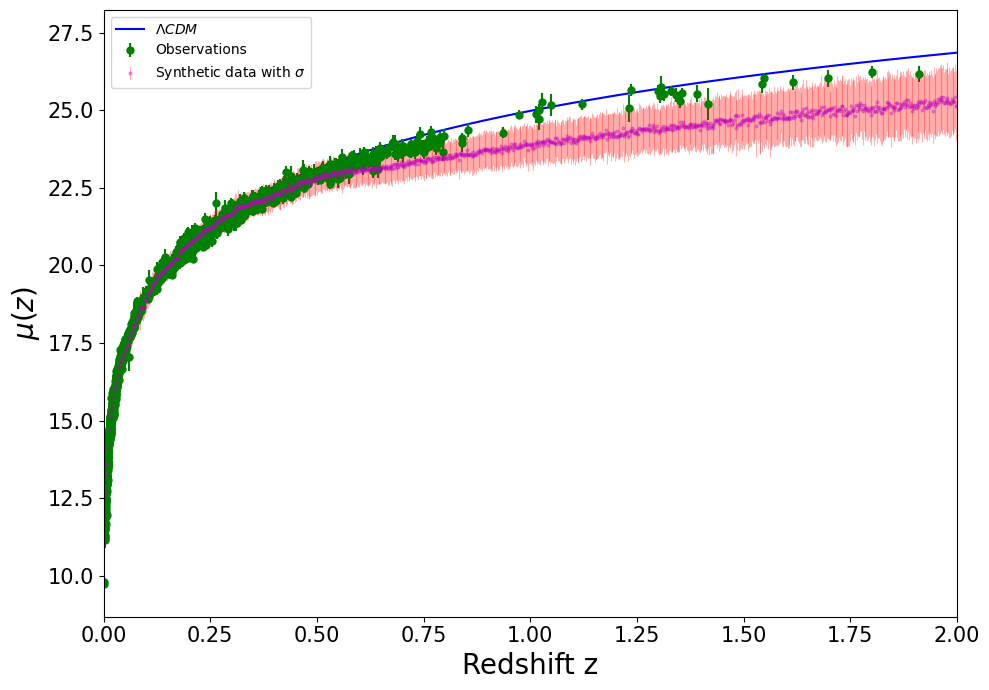

In [44]:
# Plotting
plt.figure(figsize=(10, 7), dpi=100)
# plt.figure(figsize=(5, 4), dpi=100)
sigma = np.sqrt(std_mc_dropout[:, 0]**2 + std_mc_dropout[:, 1]**2+ prediction_mc_dropout[:,1]**2)


# plt.scatter(scalerz.inverse_transform(zz), yy, color='k', label='Original cosmic chronometers')
plt.plot(zmodel, flcdm, label='$\Lambda CDM$', c='b')
plt.errorbar(df['zHD'], df['m_b_corr'], df['errors'], fmt='g.', markersize=10, label='Observations')
plt.errorbar(x_test, prediction_mc_dropout[:,0], yerr=sigma, markersize=2, fmt='o', 
             ecolor='r', capthick=2, elinewidth=0.8, alpha=0.3, c='m',
             label='Synthetic data with $\sigma$')

plt.xlim(0,2)

# plt.xlabel('Redshift')
# plt.ylabel('$H(z)$')
plt.ylabel("$\mu(z)$", fontsize=20)
plt.xlabel("Redshift z", fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(loc='best')
plt.legend(loc='upper left')
# plt.show()
plt.tight_layout()


In [45]:
 prediction_mc_dropout[0,:]

array([11.97848792,  0.25941881])

([], [])

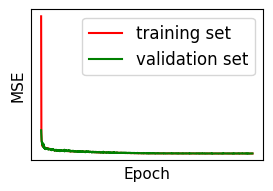

In [46]:
plt.figure(figsize=(3, 2), dpi=100)

plt.plot(model2_train.history['loss'], color='r', )
plt.plot(model2_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=12)
plt.xticks(fontsize=10)
plt.xticks([])
plt.yticks([])


In [47]:
# model.save('FFNN+MC-DO_Hz.h5')
# tf.keras.models.save_model(neural_model2, '../models/FFNN_MC_DO.h5' )

In [48]:
mookdp = np.concatenate((x_test.reshape(-1,1), prediction_mc_dropout), axis=1)

# np.savetxt("data.dat",mookdp, delimiter=" ")

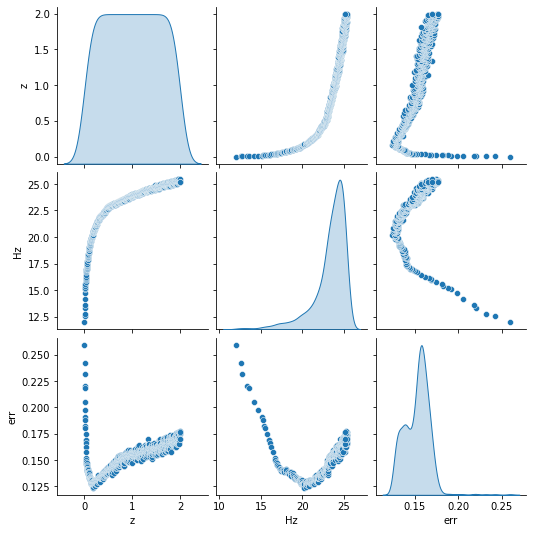

In [49]:
dfMook = pd.DataFrame(mookdp, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
# plt.savefig("50hdmookdropout.png")